In [143]:
import os
os.chdir("../scripts")

In [144]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from agents.q_agents import ElfQLearner
from tqdm.notebook import tqdm

In [145]:
exp_env = gym.make("FrozenLake-v1",
                   desc=generate_random_map(size=4),
                   is_slippery=False)

print(f"Action Space size: {exp_env.action_space.n}")
print(f"Available actions: {exp_env.action_space}")
print(f"Observation space type: {type(exp_env.observation_space.sample())}")
print(f"Sample Observation: {exp_env.observation_space.sample()}")

exp_env.close()

Action Space size: 4
Available actions: Discrete(4)
Observation space type: <class 'numpy.int64'>
Sample Observation: 11


In [146]:
class RandomFrozenLake(gym.Env):
    def __init__(self, size: int=4, is_slippery: bool=True, initial_p: float=1.0, final_p: float=.5, p_decay: float=0.001):
        self.size = size
        self.is_slippery = is_slippery
        self.env: gym.Env = None
        self.p = initial_p
        self.min_p = final_p
        self.p_decay = p_decay
    
    def _make_random_env(self):
        random_desc = generate_random_map(size=self.size, p=self.p)
        self.env = gym.make("FrozenLake-v1", desc=random_desc, is_slippery=self.is_slippery, render_mode="rgb_array")
        self.p = max(self.min_p, self.p - self.p_decay)
    
    def reset(self, **kwargs):
        self._make_random_env()
        return self.env.reset(**kwargs)

    def step(self, action):
        return self.env.step(action)

    def render(self, **kwargs):
        return self.env.render(**kwargs)
    
    def close(self):
        return self.env.close()
    
    def __getattr__(self, name):
        return getattr(self.env, name)

In [147]:
num_episodes = 100_000
start_epsilon = 1.0
end_epsilon = 0.05
epsilon_decay_rate=0.0005
gamma = 0.95
learning_rate = 0.7
max_steps = 99
env_id="FrozenLake-v1"
eval_seed=42
eval_num_episodes=1000

In [148]:
train_env = gym.make(env_id, render_mode="rgb_array", map_name="4x4", is_slippery=False)
train_env = gym.wrappers.RecordEpisodeStatistics(
    train_env, buffer_length=num_episodes
)

agent = ElfQLearner(
    env=train_env,
    learning_rate = learning_rate,
    initial_epsilon=start_epsilon,
    minimal_epsilon=end_epsilon,
    epsilon_decay_rate=epsilon_decay_rate,
    gamma=gamma
)

for i in tqdm(range(num_episodes)):
    obs, info = train_env.reset()
    _done = False
    step = 0

    while not _done and step <= max_steps:
        action = agent.get_action(obs)
        new_obs, reward, terminated, truncated, info = train_env.step(action)
        agent.update(obs, action, terminated, reward, new_obs)
        obs = new_obs

        step += 1
        _done = truncated or terminated
    
    agent.decay_epsilon()

train_env.close()

  0%|          | 0/100000 [00:00<?, ?it/s]

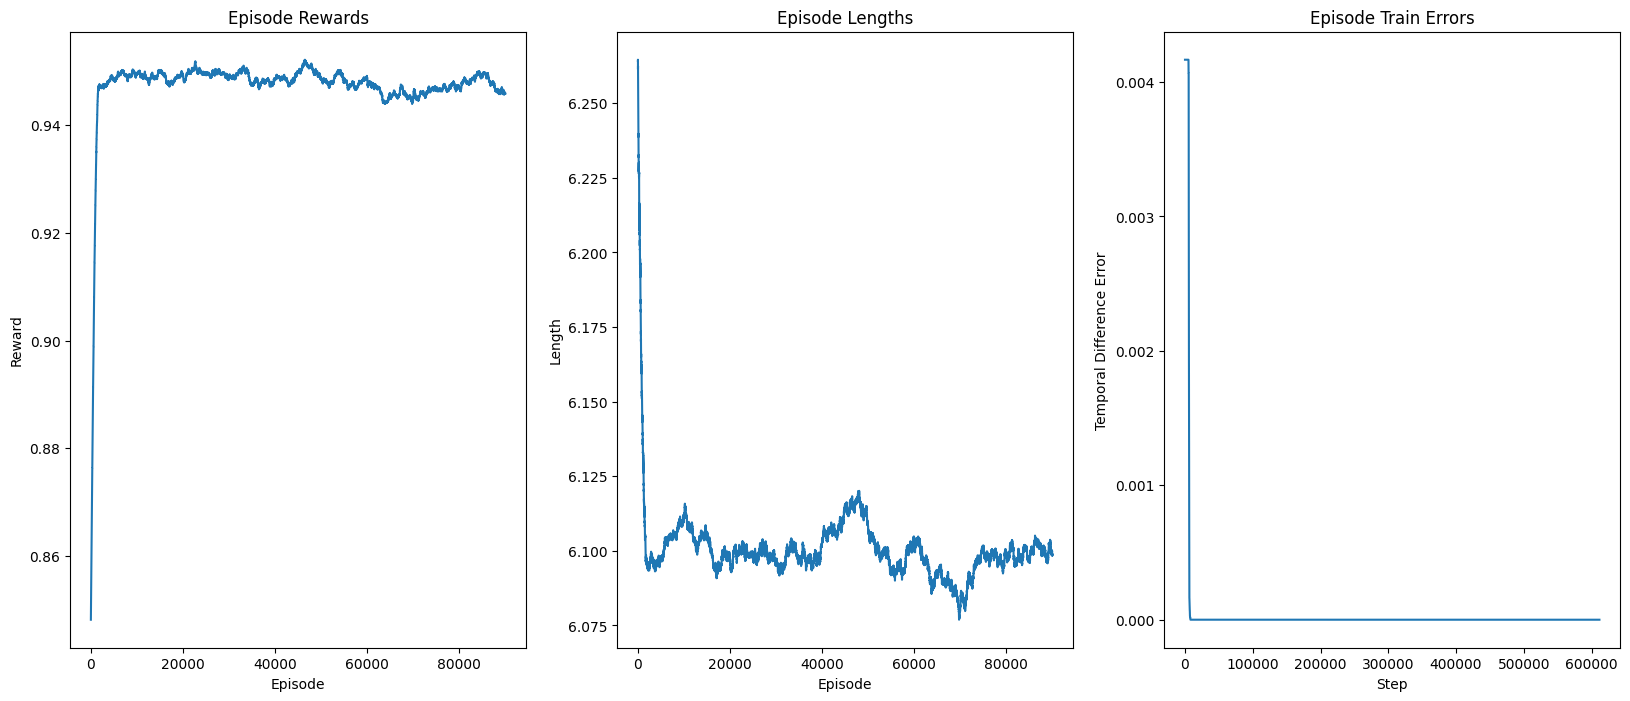

In [149]:
from utils.plot import plot_smooth_curve
plot_smooth_curve(agent, train_env, smoothing_window=10_000)

In [150]:
agent.q_table

defaultdict(<function agents.q_agents.ElfQLearner.__init__.<locals>.<lambda>()>,
            {'dtype': float,
             0: array([0.73509189, 0.77378094, 0.77378094, 0.73509189]),
             4: array([0.77378094, 0.81450625, 0.        , 0.73509189]),
             5: array([0., 0., 0., 0.]),
             1: array([0.73509189, 0.        , 0.81450625, 0.77378094]),
             2: array([0.77378094, 0.857375  , 0.77378094, 0.81450625]),
             6: array([0.        , 0.9025    , 0.        , 0.81450625]),
             3: array([0.81450625, 0.        , 0.77378094, 0.77378094]),
             7: array([0., 0., 0., 0.]),
             8: array([0.81450625, 0.        , 0.857375  , 0.77378094]),
             12: array([0., 0., 0., 0.]),
             9: array([0.81450625, 0.9025    , 0.9025    , 0.        ]),
             13: array([0.      , 0.9025  , 0.95    , 0.857375]),
             10: array([0.857375, 0.95    , 0.      , 0.857375]),
             14: array([0.9025, 0.95  , 1.    , 0.

In [151]:
import numpy as np

def evaluate_agent(agent, env, n_eval_episodes, seed=None):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param Q: The Q-table
    :param seed: The evaluation seed array (for taxi-v3)
    """

    backup_epsilon = agent.epsilon
    agent.epsilon = 0

    episode_rewards = np.zeros(shape=(n_eval_episodes,))
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            obs, info = env.reset(seed=seed + episode)
        else:
            obs, info = env.reset()

        _done = False
        cumulative_reward = 0

        while not _done:
            # Take the action (index) that have the maximum expected future reward given that state
            action = agent.get_action(obs)
            new_state, reward, terminated, truncated, info = env.step(action)
            cumulative_reward += reward
            obs = new_state

            _done = truncated or terminated

        episode_rewards[episode] = cumulative_reward

    print(episode_rewards)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    agent.epsilon = backup_epsilon

    return mean_reward, std_reward

In [152]:
eval_env = gym.make("FrozenLake-v1", render_mode="rgb_array", map_name="4x4", is_slippery=False)
mean_reward, std_reward = evaluate_agent(
    agent,
    eval_env,
    n_eval_episodes=eval_num_episodes,
    seed=eval_seed
)

print(f"Reward = {mean_reward} +/- {std_reward}")

eval_env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.